<a href="https://colab.research.google.com/github/VenGr0/RNN/blob/main/%D0%94%D0%BE%D0%BC%D0%B0%D1%88%D0%BD%D1%8F%D1%8F_%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D0%B0_21_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Загрузка данных и установка библиотек

In [ ]:
# Загрузим датасет
!wget https://storage.yandexcloud.net/academy.ai/russian_literature.zip

# Разархивируем датасета во временную папку 'dataset'
!unzip -qo "russian_literature" -d ./dataset

!dir ./dataset/prose

!dir ./dataset/poems

!wget https://storage.yandexcloud.net/natasha-navec/packs/navec_hudlit_v1_12B_500K_300d_100q.tar

!pip install navec

--2024-03-17 09:18:28--  https://storage.yandexcloud.net/academy.ai/russian_literature.zip
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21547079 (21M) [application/x-zip-compressed]
Saving to: ‘russian_literature.zip’

russian_literature. 100%[===================>]  20.55M  6.66MB/s    in 4.0s    

2024-03-17 09:18:34 (5.15 MB/s) - ‘russian_literature.zip’ saved [21547079/21547079]

error:  cannot create ./dataset/poems/Blok/╨б╤В╨╕╤Е╨╛╤В╨▓╨╛╤А╨╡╨╜╨╕╤П 1897-1903 ╨│╨│, ╨╜╨╡ ╨▓╨╛╤И╨╡╨┤╤И╨╕╨╡ ╨▓ ╨╛╤Б╨╜╨╛╨▓╨╜╨╛╨╡ ╤Б╨╛╨▒╤А╨░╨╜╨╕╨╡.txt
        File name too long
error:  cannot create ./dataset/prose/Gogol/╨Я╨╛╨▓╨╡╤Б╤В╤М ╨╛ ╤В╨╛╨╝, ╨║╨░╨║ ╨┐╨╛╤Б╤Б╨╛╤А╨╕╨╗╤Б╤П ╨Ш╨▓╨░╨╜ ╨Ш╨▓╨░╨╜╨╛╨▓╨╕╤З ╤Б ╨Ш╨▓╨░╨╜╨╛╨╝ ╨Э╨╕╨║╨╕╤Д╨╛╤А╨╛╨▓╨╕╤З╨╡╨╝.txt
        File name too long
error:  cannot create ./dataset/publi

## Далее

### Библиотеки

In [ ]:
# Загрузка необходимых библиотек
import glob # Вспомогательный модуль для работы с файловой системой
import numpy as np
from navec import Navec
import keras
from re import X
from keras import utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, SpatialDropout1D, BatchNormalization, Embedding, Flatten, Activation, SimpleRNN
from keras.layers import Embedding, Flatten, Dense, SpatialDropout1D, BatchNormalization, Dropout, SimpleRNN
from keras.layers import GRU, LSTM, Bidirectional, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from keras.preprocessing.text import Tokenizer
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from keras.optimizers import SGD, Adam, RMSprop, AdamW, Adadelta, Adagrad, Adamax
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

### Подготовка данных с балансировкой

Датасет состоит из 38146925 символов

Общая выборка по писателям (по символам):
Dostoevsky - 11221679 символов, доля в общей базе: 29.42%
Tolstoy - 9392435 символов, доля в общей базе: 24.62%
Turgenev - 2345243 символов, доля в общей базе: 6.15%
Chekhov - 1834330 символов, доля в общей базе: 4.81%
Lermontov - 364382 символов, доля в общей базе: 0.96%
Blok - 604204 символов, доля в общей базе: 1.58%
Pushkin - 1399557 символов, доля в общей базе: 3.67%
Gogol - 2196599 символов, доля в общей базе: 5.76%
Gorky - 4324025 символов, доля в общей базе: 11.34%
Herzen - 1282316 символов, доля в общей базе: 3.36%
Bryusov - 2830897 символов, доля в общей базе: 7.42%
Nekrasov - 351258 символов, доля в общей базе: 0.92%

Общая выборка по писателям (по словам):
Dostoevsky - 1779919 слов, доля в общей базе: 29.97%
Tolstoy - 1456418 слов, доля в общей базе: 24.53%
Turgenev - 365152 слов, доля в общей базе: 6.15%
Chekhov - 291031 слов, доля в общей базе: 4.90%
Lermontov - 55465 слов, доля в общей базе: 

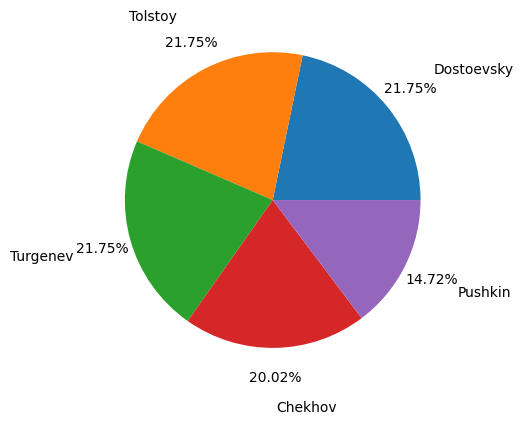

In [ ]:
navec = Navec.load('navec_hudlit_v1_12B_500K_300d_100q.tar')

# Выбираем их явно, чтобы список был перед глазами, и отложилось в голове, что имена писателей (точнее их порядковый номер) - это метки
CLASS_LIST=["Dostoevsky", "Tolstoy", "Turgenev", "Chekhov", "Lermontov", "Blok", "Pushkin", "Gogol", "Gorky", "Herzen", "Bryusov", "Nekrasov" ]

all_texts = {} # Собираем в словарь весь датасет

for author in CLASS_LIST:
  all_texts[author] = '' # Инициализируем пустой строкой новый ключ словаря
  for path in glob.glob('./dataset/prose/{}/*.txt'.format(author)) +  glob.glob('./dataset/poems/{}/*.txt'.format(author)): # Поиск файлов по шаблону
    with open(f'{path}', 'r', errors='ignore') as f: # игнорируем ошибки (например символы из другой кодировки)
                # Загрузка содержимого файла в строку
                text = f.read()

    all_texts[author]  += ' ' + text.replace('\n', ' ') # Заменяем символ перехода на новую строку пробелом

# используем генератор цикла для получения длины текстов по каждому автору
total = sum(len(i) for i in all_texts.values())
print(f'Датасет состоит из {total} символов')
print('')

print('Общая выборка по писателям (по символам):')
for author in CLASS_LIST:
    # удобный метод форматирования 2 знака после запятой f'{ВЫРАЖЕНИЕ:.2f}'
    print(f'{author} - {len(all_texts[author])} символов, доля в общей базе: {len(all_texts[author])/total*100 :.2f}%')

NUM_WORDS = 15000 # Размер словаря

# Используется встроенный в Keras токенизатор для разбиения текста и построения частотного словаря
tokenizer = Tokenizer(num_words=NUM_WORDS,
                      filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff',
                      lower=True, split=' ', oov_token='неизвестное_слово', char_level=False)


# Преобразование текста в последовательности
tokenizer.fit_on_texts(all_texts.values())

seq_train = tokenizer.texts_to_sequences(all_texts.values())
total = sum(len(i) for i in seq_train)

print('')
print('Общая выборка по писателям (по словам):')
mean_list = np.array([])
for author in CLASS_LIST:
    cls = CLASS_LIST.index(author)
    print(f'{author} - {len(seq_train[cls])} слов, доля в общей базе: {len(seq_train[cls])/total*100 :.2f}%')
    mean_list = np.append(mean_list, len(seq_train[cls]))

median = int(np.median(mean_list)) # Зафиксировали медианное значение
CLASS_LIST_BALANCE = [] # Сбалансированный набор меток
seq_train_balance = []
selected_authors = 5 # Количество авторов, которых нужно выбрать

for author in CLASS_LIST:
    cls = CLASS_LIST.index(author)
    if len(seq_train[cls]) > median * 0.6 and len(CLASS_LIST_BALANCE) < selected_authors:
        seq_train_balance.append(seq_train[cls][:median])
        CLASS_LIST_BALANCE.append(author)

        # Условие на выбор только 5-х авторов
        if len(CLASS_LIST_BALANCE) == selected_authors:
            break

print('')
print('Сбалансированная выборка по писателям (по словам):')
mean_list_balance = np.array([])
for author in CLASS_LIST_BALANCE:
    cls = CLASS_LIST_BALANCE.index(author)
    print(f'{author} - {len(seq_train_balance[cls])} слов, доля в общей базе: {len(seq_train_balance[cls])/total*100 :.2f}%')
    mean_list_balance = np.append(mean_list_balance, len(seq_train_balance[cls]))

print('Среднее значение слов: ', np.round(mean_list_balance.mean()))
print('Медианное значение слов: ', np.median(mean_list_balance))

fig, ax = plt.subplots()
ax.pie([len(i) for i in seq_train_balance],  # формируем список значений как длина символов текста каждого автора
       labels=CLASS_LIST_BALANCE,            # список меток
       pctdistance=1.2,                      # дистанция размещения % (1 - граница окружности)
       labeldistance=1.4,                    # размещение меток (1 - граница окружности)
       autopct='%1.2f%%'                     # формат для % (2 знака после запятой)
      )
plt.show()

In [ ]:
WIN_SIZE = 1000   # Ширина окна в токенах
WIN_STEP = 50    # Шаг окна в токенах
EMBEDDING_GIM = 300

# Функция разбиения последовательности на отрезки скользящим окном
# Последовательность разбивается на части до последнего полного окна
# Параметры:
# sequence - последовательность токенов
# win_size - размер окна
# step - шаг окна
def seq_split(sequence, win_size, step):
    # Делим строку на отрезки с помощью генератора цикла
    return [sequence[i:i + win_size] for i in range(0, len(sequence) - win_size + 1, step)]

# Функция векторизации последовательности и деление на входные и выходные данные:
def seq_vectorize(
    seq_list,   # Последовательность
    test_split, # Доля на тестовую выборку
    class_list, # Список классов
    win_size,   # Ширина скользящего окна
    step        # Шаг скользящего окна
):

    # Списки для результирующих данных
    x_train, y_train, x_val, y_val, x_test, y_test =  [], [], [], [], [], []

    # Пробежимся по всем классам:
    for class_item in class_list:
        # Получим индекс класса
        cls = class_list.index(class_item)

        # Пороговое значение индекса для разбивки на тестовую и обучающую выборки
        valid_split = int(len(seq_list[cls]) * (1-test_split))
        train_split = int(len(seq_list[cls]) * (1-test_split*2))

        # Разбиваем последовательность токенов класса на отрезки
        vectors_train = seq_split(seq_list[cls][:train_split], win_size, step) # последовательность до порога попадет в обучающую выборку
        vectors_val = seq_split(seq_list[cls][train_split:valid_split], win_size, step) # последовательность до порога попадет в обучающую выборку
        vectors_test = seq_split(seq_list[cls][valid_split:], win_size, step)  # последовательность после порога попадет в тестовую выборку

        # Добавляем отрезки в выборку
        x_train += vectors_train
        x_val += vectors_val
        x_test += vectors_test

        # Для всех отрезков класса добавляем метки класса в виде one-hot-encoding
        # Каждую метку берем len(vectors) раз, так она одинакова для всех выборок одного класса
        y_train += [utils.to_categorical(cls, len(class_list))] * len(vectors_train)
        y_val += [utils.to_categorical(cls, len(class_list))] * len(vectors_val)
        y_test += [utils.to_categorical(cls, len(class_list))] * len(vectors_test)

    # Возвращаем результатов как numpy-массивов
    return np.array(x_train), np.array(y_train), np.array(x_val), np.array(y_val), np.array(x_test), np.array(y_test)

# Вывод графиков точности и ошибки
def show_plot(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))
    fig.suptitle('График процесса обучения модели')
    ax1.plot(history.history['accuracy'],
               label='График точности на обучающей выборке')
    ax1.plot(history.history['val_accuracy'],
               label='График точности на проверочной выборке')
    ax1.xaxis.get_major_locator().set_params(integer=True) # На оси х показываем целые числа
    ax1.set_xlabel('Эпоха обучения')
    ax1.set_ylabel('График точности')
    ax1.legend()

    ax2.plot(history.history['loss'],
               label='Ошибка на обучающей выборке')
    ax2.plot(history.history['val_loss'],
               label='Ошибка на проверочной выборке')
    ax2.xaxis.get_major_locator().set_params(integer=True) # На оси х показываем целые числа
    ax2.set_xlabel('Эпоха обучения')
    ax2.set_ylabel('Ошибка')
    ax2.legend()
    plt.show()

# Функция вывода предсказанных значений
def show_confusion_matrix(y_true, y_pred, class_labels):
    # Матрица ошибок
    cm = confusion_matrix(np.argmax(y_true, axis=1),
                          np.argmax(y_pred, axis=1),
                          normalize='true')
    # Округление значений матрицы ошибок
    cm = np.around(cm, 3)

    # Отрисовка матрицы ошибок
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_title(f'Матрица ошибок', fontsize=18)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(ax=ax)
    plt.gca().images[-1].colorbar.remove()  # Убираем ненужную цветовую шкалу
    plt.xlabel('Предсказанные классы', fontsize=16)
    plt.ylabel('Верные классы', fontsize=16)
    fig.autofmt_xdate(rotation=45)          # Наклон меток горизонтальной оси
    plt.show()


    # Средняя точность распознавания определяется как среднее диагональных элементов матрицы ошибок
    print('\nСредняя точность распознавания: {:3.0f}%'.format(100. * cm.diagonal().mean()))

# Функция загрузки в модель весов Наташи для Embedding:
def loadEmbedding(model):
    word_index = tokenizer.word_index
    embeddings_index = navec

    embedding_matrix = np.zeros((NUM_WORDS, EMBEDDING_GIM))
    for word, i in word_index.items():
        if i < NUM_WORDS:
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector

    model.layers[0].set_weights([embedding_matrix])
    model.layers[0].trainable = False
    return model

# x, y = seq_vectorize(seq_train, CLASS_LIST, WIN_SIZE, WIN_STEP)

# print(f'Форма всех входных данных: {x.shape}')
# print(f'Форма всех выходных данных (меток): {y.shape}')

# x_train, x_test, y_train, y_test = train_test_split(x, y,
#                                                     train_size=0.8,
#                                                     random_state=123)

# x_val, x_test, y_val, y_test = train_test_split(x_test, y_test,
#                                                     train_size=0.5,
#                                                     random_state=123)

x_train, y_train, x_val, y_val, x_test, y_test = seq_vectorize(seq_train_balance, 0.1, CLASS_LIST_BALANCE, WIN_SIZE, WIN_STEP)

print(f'Форма входных данных для обучающей выборки: {x_train.shape}')
print(f'Форма выходных данных (меток) для обучающей выборки: {y_train.shape}')

print(f'Форма входных данных для проверочной выборки: {x_val.shape}')
print(f'Форма выходных данных (меток) для проверочной выборки: {y_val.shape}')

print(f'Форма входных данных для тестовой выборки: {x_test.shape}')
print(f'Форма выходных данных (меток) для тестовой выборки: {y_test.shape}')

Форма входных данных для обучающей выборки: (23159, 1000)
Форма выходных данных (меток) для обучающей выборки: (23159, 5)
Форма входных данных для проверочной выборки: (2811, 1000)
Форма выходных данных (меток) для проверочной выборки: (2811, 5)
Форма входных данных для тестовой выборки: (2811, 1000)
Форма выходных данных (меток) для тестовой выборки: (2811, 5)


### Настройка и тест модели

In [ ]:
model = Sequential()
model.add(Embedding(NUM_WORDS, EMBEDDING_GIM, input_length=WIN_SIZE))
model.add(SpatialDropout1D(0.3))
model.add(BatchNormalization())

# Два двунаправленных рекуррентных слоя LSTM
model.add(Bidirectional(LSTM(8, return_sequences=True)))
model.add(Bidirectional(LSTM(8, return_sequences=True)))
model.add(Dropout(0.3))
model.add(BatchNormalization())

# Два рекуррентных слоя GRU
model.add(GRU(16, return_sequences=True, reset_after=True))
model.add(GRU(16, reset_after=True))
model.add(Dropout(0.3))
model.add(BatchNormalization())

# Дополнительный полносвязный слой
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Dense(len(CLASS_LIST_BALANCE), activation='softmax'))

model = loadEmbedding(model)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

callbacks = [
    keras.callbacks.ModelCheckpoint(filepath = 'best_model_pretrain.keras',
                             monitor = 'val_accuracy',
                             save_best_only = True,
                             mode = 'max',
                             verbose = 0)
]

history = model.fit(x_train, y_train, epochs=30, batch_size=128, validation_data=(x_val, y_val), callbacks=callbacks)

Epoch 1/30
181/181 [==============================] - 55s 224ms/step - loss: 1.8085 - accuracy: 0.2279 - val_loss: 1.5886 - val_accuracy: 0.2280
Epoch 2/30
181/181 [==============================] - 34s 187ms/step - loss: 1.5836 - accuracy: 0.2791 - val_loss: 1.5323 - val_accuracy: 0.3109
Epoch 3/30
181/181 [==============================] - 32s 175ms/step - loss: 1.4650 - accuracy: 0.3267 - val_loss: 1.6222 - val_accuracy: 0.3212
Epoch 4/30
181/181 [==============================] - 33s 185ms/step - loss: 1.4839 - accuracy: 0.3329 - val_loss: 1.4493 - val_accuracy: 0.3508
Epoch 5/30
181/181 [==============================] - 33s 183ms/step - loss: 1.3814 - accuracy: 0.3843 - val_loss: 1.4167 - val_accuracy: 0.3689
Epoch 6/30
181/181 [==============================] - 33s 183ms/step - loss: 1.2262 - accuracy: 0.4689 - val_loss: 1.7408 - val_accuracy: 0.2472
Epoch 7/30
181/181 [==============================] - 33s 181ms/step - loss: 1.0268 - accuracy: 0.5636 - val_loss: 1.4677 - val_ac

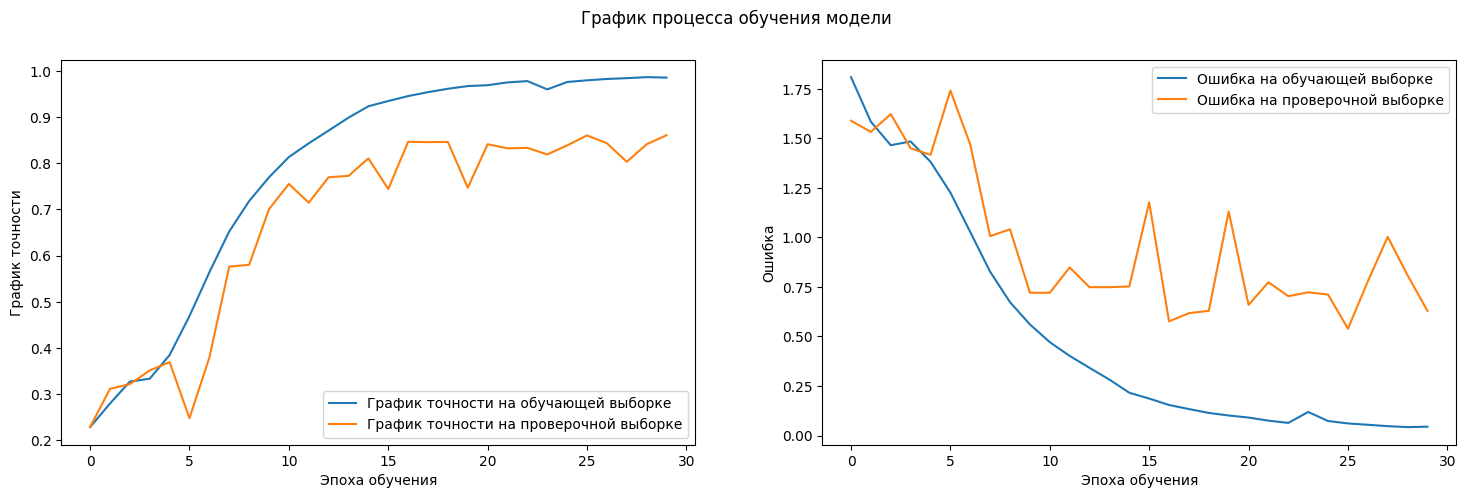

In [ ]:
show_plot(history)

88/88 [==============================] - 8s 71ms/step


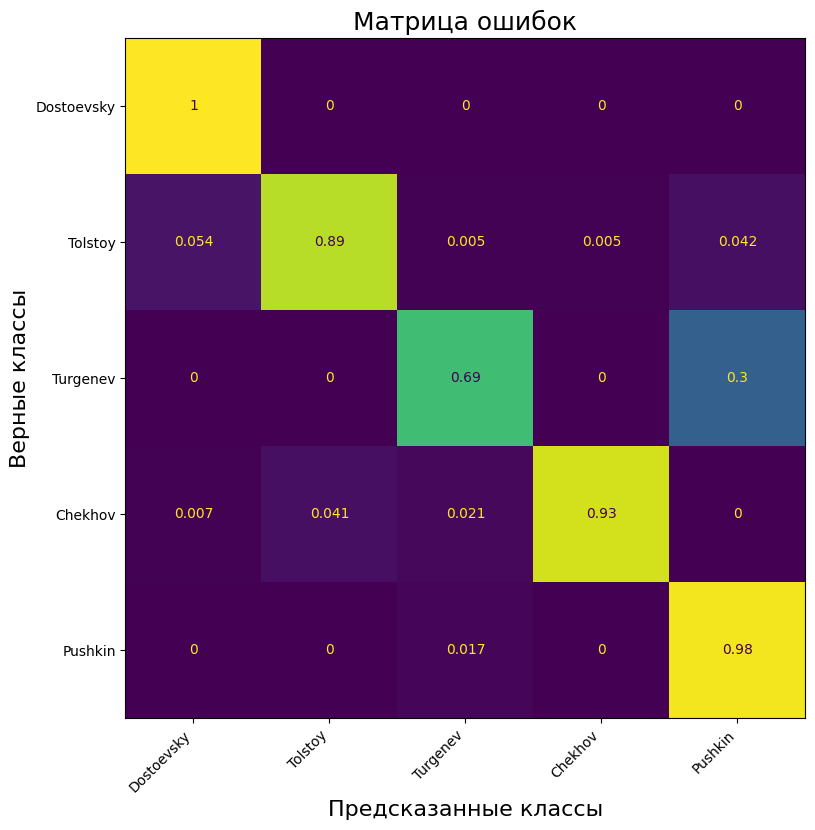


Средняя точность распознавания:  90%


In [ ]:
y_pred = model.predict(x_test)
show_confusion_matrix(y_test, y_pred, CLASS_LIST_BALANCE)

# Доп задание

In [ ]:
# В честь праздника напишем небольшой текст про Масленицу
own_text = '''Праздник Масленицы – это один из самых древних и веселых праздников, который отмечается перед Великим постом в православной и католической церкви. Масленица символизирует прощание с зимой и встречу весны. Этот праздник сопровождается множеством традиций и обрядов, которые люди соблюдают с особым весельем и энтузиазмом.

Продолжительность и даты: Подготовка к Масленице начинается задолго до самого праздника. Жители готовят разнообразные блюда, связанные с этим праздником, такие как блины, масло, мед, варенье и другие вкусности. Также важным элементом подготовки является наряжение дома весенними и яркими украшениями, чтобы создать праздничную атмосферу.Масленица длится неделю и обычно приходится на последнюю неделю перед Великим постом. Даты празднования определяются по православному календарю и уточняются каждый год.

Обряды и традиции: Одним из символов Масленицы является масленичный кукла – пирожок в виде человечка, который сжигается в конце праздника. Во время Масленицы люди устраивают катание на санках, падаются снежками, устраивают праздничные гулянья на улицах. Важным обрядом является прыжки через костер, которые символизируют очищение от грехов и пожелания удачи.

Питание: Во время Масленицы широко употребляются блюда из масла, муки и яиц. На праздничном столе обязательно присутствуют блины - тонкие лепешки, которые подаются с маслом, икрой, копченостями, джемом и другими начинками. Традиционно на столе Масленицы также могут быть оладьи, самсы, пироги и медовуха.

Развлечения: Во время Масленицы проводятся различные народные гулянья, масленичные гулянья, гадания. Также популярными развлечениями являются гуляния на санях, песни, танцы и игры. Важным моментом является масленичный поход, когда люди идут на природу отмечать праздник весны. Особенно популярными являются различные конкурсы и игры, которые проводятся во время Масленицы. Например, конкурс на самые веселые костюмы, состязания по скорости и ловкости.

Завершение: Масленица завершается прощеной неделей, после чего начинается Великий пост. В последний день Масленицы обычно устраивают масленичное опричное шествие с масленичным куклом, который потом сжигается на костре.

Масленица - это время веселья, радости и общения с близкими. Этот праздник позволяет каждому отдохнуть от забот и насладиться весенней атмосферой.'''

own_text = own_text.replace('\n', ' ') # Заменяем символ перехода на новую строку пробелом

seq_own_text = sum(tokenizer.texts_to_sequences(own_text), []) # Преобразуем обученным токенайзером текст с переводом в одномерный список

x_sample_train = np.array(seq_split(seq_own_text, WIN_SIZE, WIN_STEP)) # Создадим эмбединг
x_sample_train.shape


(19, 1000)

In [ ]:
pred_probs = model.predict(x_sample_train) # Получение предсказания на тексте
predict_classes=np.argmax(pred_probs,axis=1) # Выдели к каким классам НС относит наш текст
print(CLASS_LIST_BALANCE)
predict_classes

1/1 [==============================] - 0s 124ms/step
['Dostoevsky', 'Tolstoy', 'Turgenev', 'Chekhov', 'Pushkin']


array([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4])

Каждый эмбединг определился как Пушкин

In [ ]:
pred_probs # Рассмотрим поподробнее

array([[1.53135093e-09, 6.59139303e-08, 1.10935900e-08, 1.03113698e-12,
        9.99999881e-01],
       [1.82889703e-09, 7.31910177e-08, 1.06603837e-08, 1.04113885e-12,
        9.99999881e-01],
       [1.53974489e-09, 6.48888161e-08, 1.15097931e-08, 1.06786357e-12,
        9.99999881e-01],
       [3.79723586e-09, 1.09610880e-07, 2.04813979e-08, 2.17254101e-12,
        9.99999881e-01],
       [1.72917214e-09, 8.26574009e-08, 1.11818972e-08, 1.20762233e-12,
        9.99999881e-01],
       [8.30804758e-09, 1.43535217e-07, 2.77625887e-08, 3.11667207e-12,
        9.99999762e-01],
       [1.33956402e-09, 7.38792636e-08, 1.08848317e-08, 1.12099772e-12,
        9.99999881e-01],
       [1.04125364e-09, 6.95927014e-08, 1.54982267e-08, 1.41041627e-12,
        9.99999881e-01],
       [9.28958466e-10, 7.65423351e-08, 1.16924506e-08, 1.19112890e-12,
        9.99999881e-01],
       [1.39796186e-09, 8.52426965e-08, 1.11378791e-08, 1.19102438e-12,
        9.99999881e-01],
       [6.81079693e-10, 4.7173

In [ ]:
x = [sum(pred_probs[:,i]) for i in range(5) ] # выделим вероятности предсказания по каждому классу
x

[3.944178211812144e-08,
 1.5682401475203278e-06,
 2.490214559003334e-07,
 2.551074596793962e-11,
 18.9999977350235]

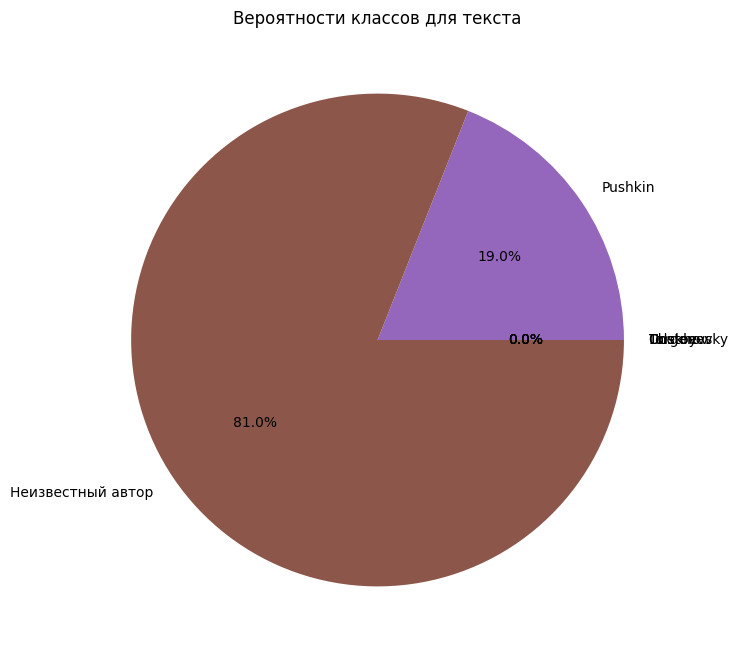

In [ ]:
# Добавим неопределенный класс для авторства текста
x.append(100-sum(x))
CLASS_LIST_BALANCE.append('Неизвестный автор')
# Изобразим круговую вероятность по предикту своего текста
plt.figure(figsize=(8, 8))
plt.pie(x, labels=CLASS_LIST_BALANCE, autopct='%1.1f%%')
plt.title('Вероятности классов для текста')
plt.show()

## Вывод:
По мнению НС больше всего текст был похож на Пушкина. Но все же вероятность не сильно большая, менее 20 процентов.